In [69]:
import pickle as pk
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection


In [45]:
cachefile = open("grouped.pkl", 'rb')
data = pk.load(cachefile)
cachefile.close()
data.head()

point  ride  rider       ilon       ilat       ielev  \
rider ride                                                              
0     0    0  0.000000   0.0    0.0 -46.691410 -23.562747  747.000000   
           1  0.027027   0.0    0.0 -46.691405 -23.562743  747.054054   
           2  0.054054   0.0    0.0 -46.691401 -23.562738  747.108108   
           3  0.081081   0.0    0.0 -46.691396 -23.562734  747.162162   
           4  0.108108   0.0    0.0 -46.691392 -23.562730  747.216216   

                     itime       flon       flat       felev         ftime  \
rider ride                                                                   
0     0    0  1.496510e+09 -46.691405 -23.562743  747.054054  1.496510e+09   
           1  1.496510e+09 -46.691401 -23.562738  747.108108  1.496510e+09   
           2  1.496510e+09 -46.691396 -23.562734  747.162162  1.496510e+09   
           3  1.496510e+09 -46.691392 -23.562730  747.216216  1.496510e+09   
           4  1.496510e+09 -46.691387 -23.562726  747.270270  1.496510e+09   

                  dist    heading         ddist     delev     climb  
rider ride                                                           
0     0    0  0.665167  46.926654  6.651668e-01  0.054054  0.081264  
           1  0.665167  46.926654  1.014265e-08  0.054054  0.081264  
           2  0.665167  46.926654  1.105071e-08  0.054054  0.081264  
           3  0.665167  46.926654  1.034407e-08  0.054054  0.081264  
           4  0.665167  46.926655  1.084928e-08  0.054054  0.081264

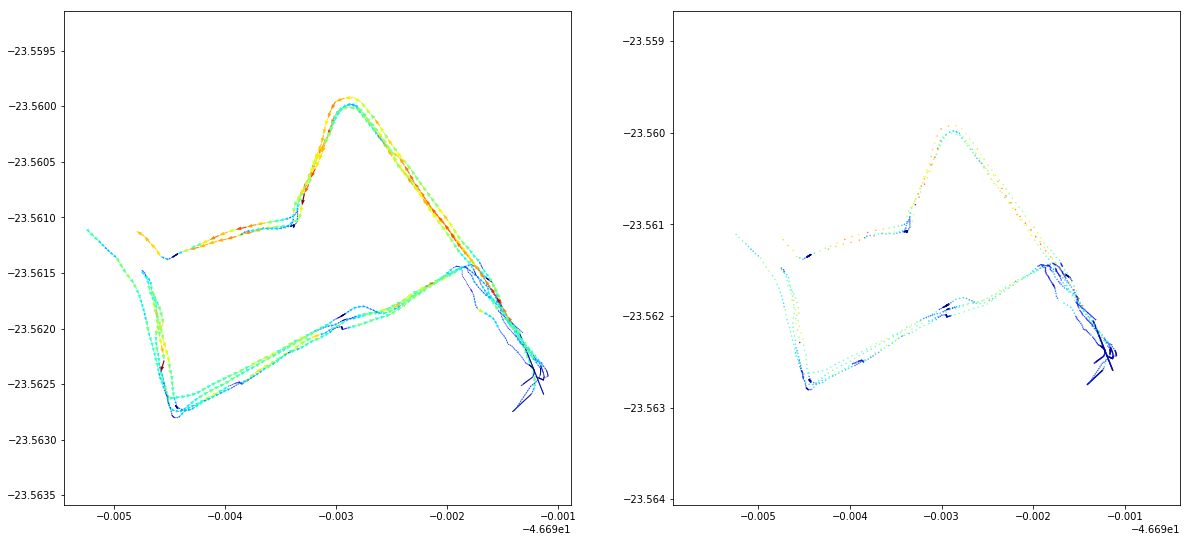

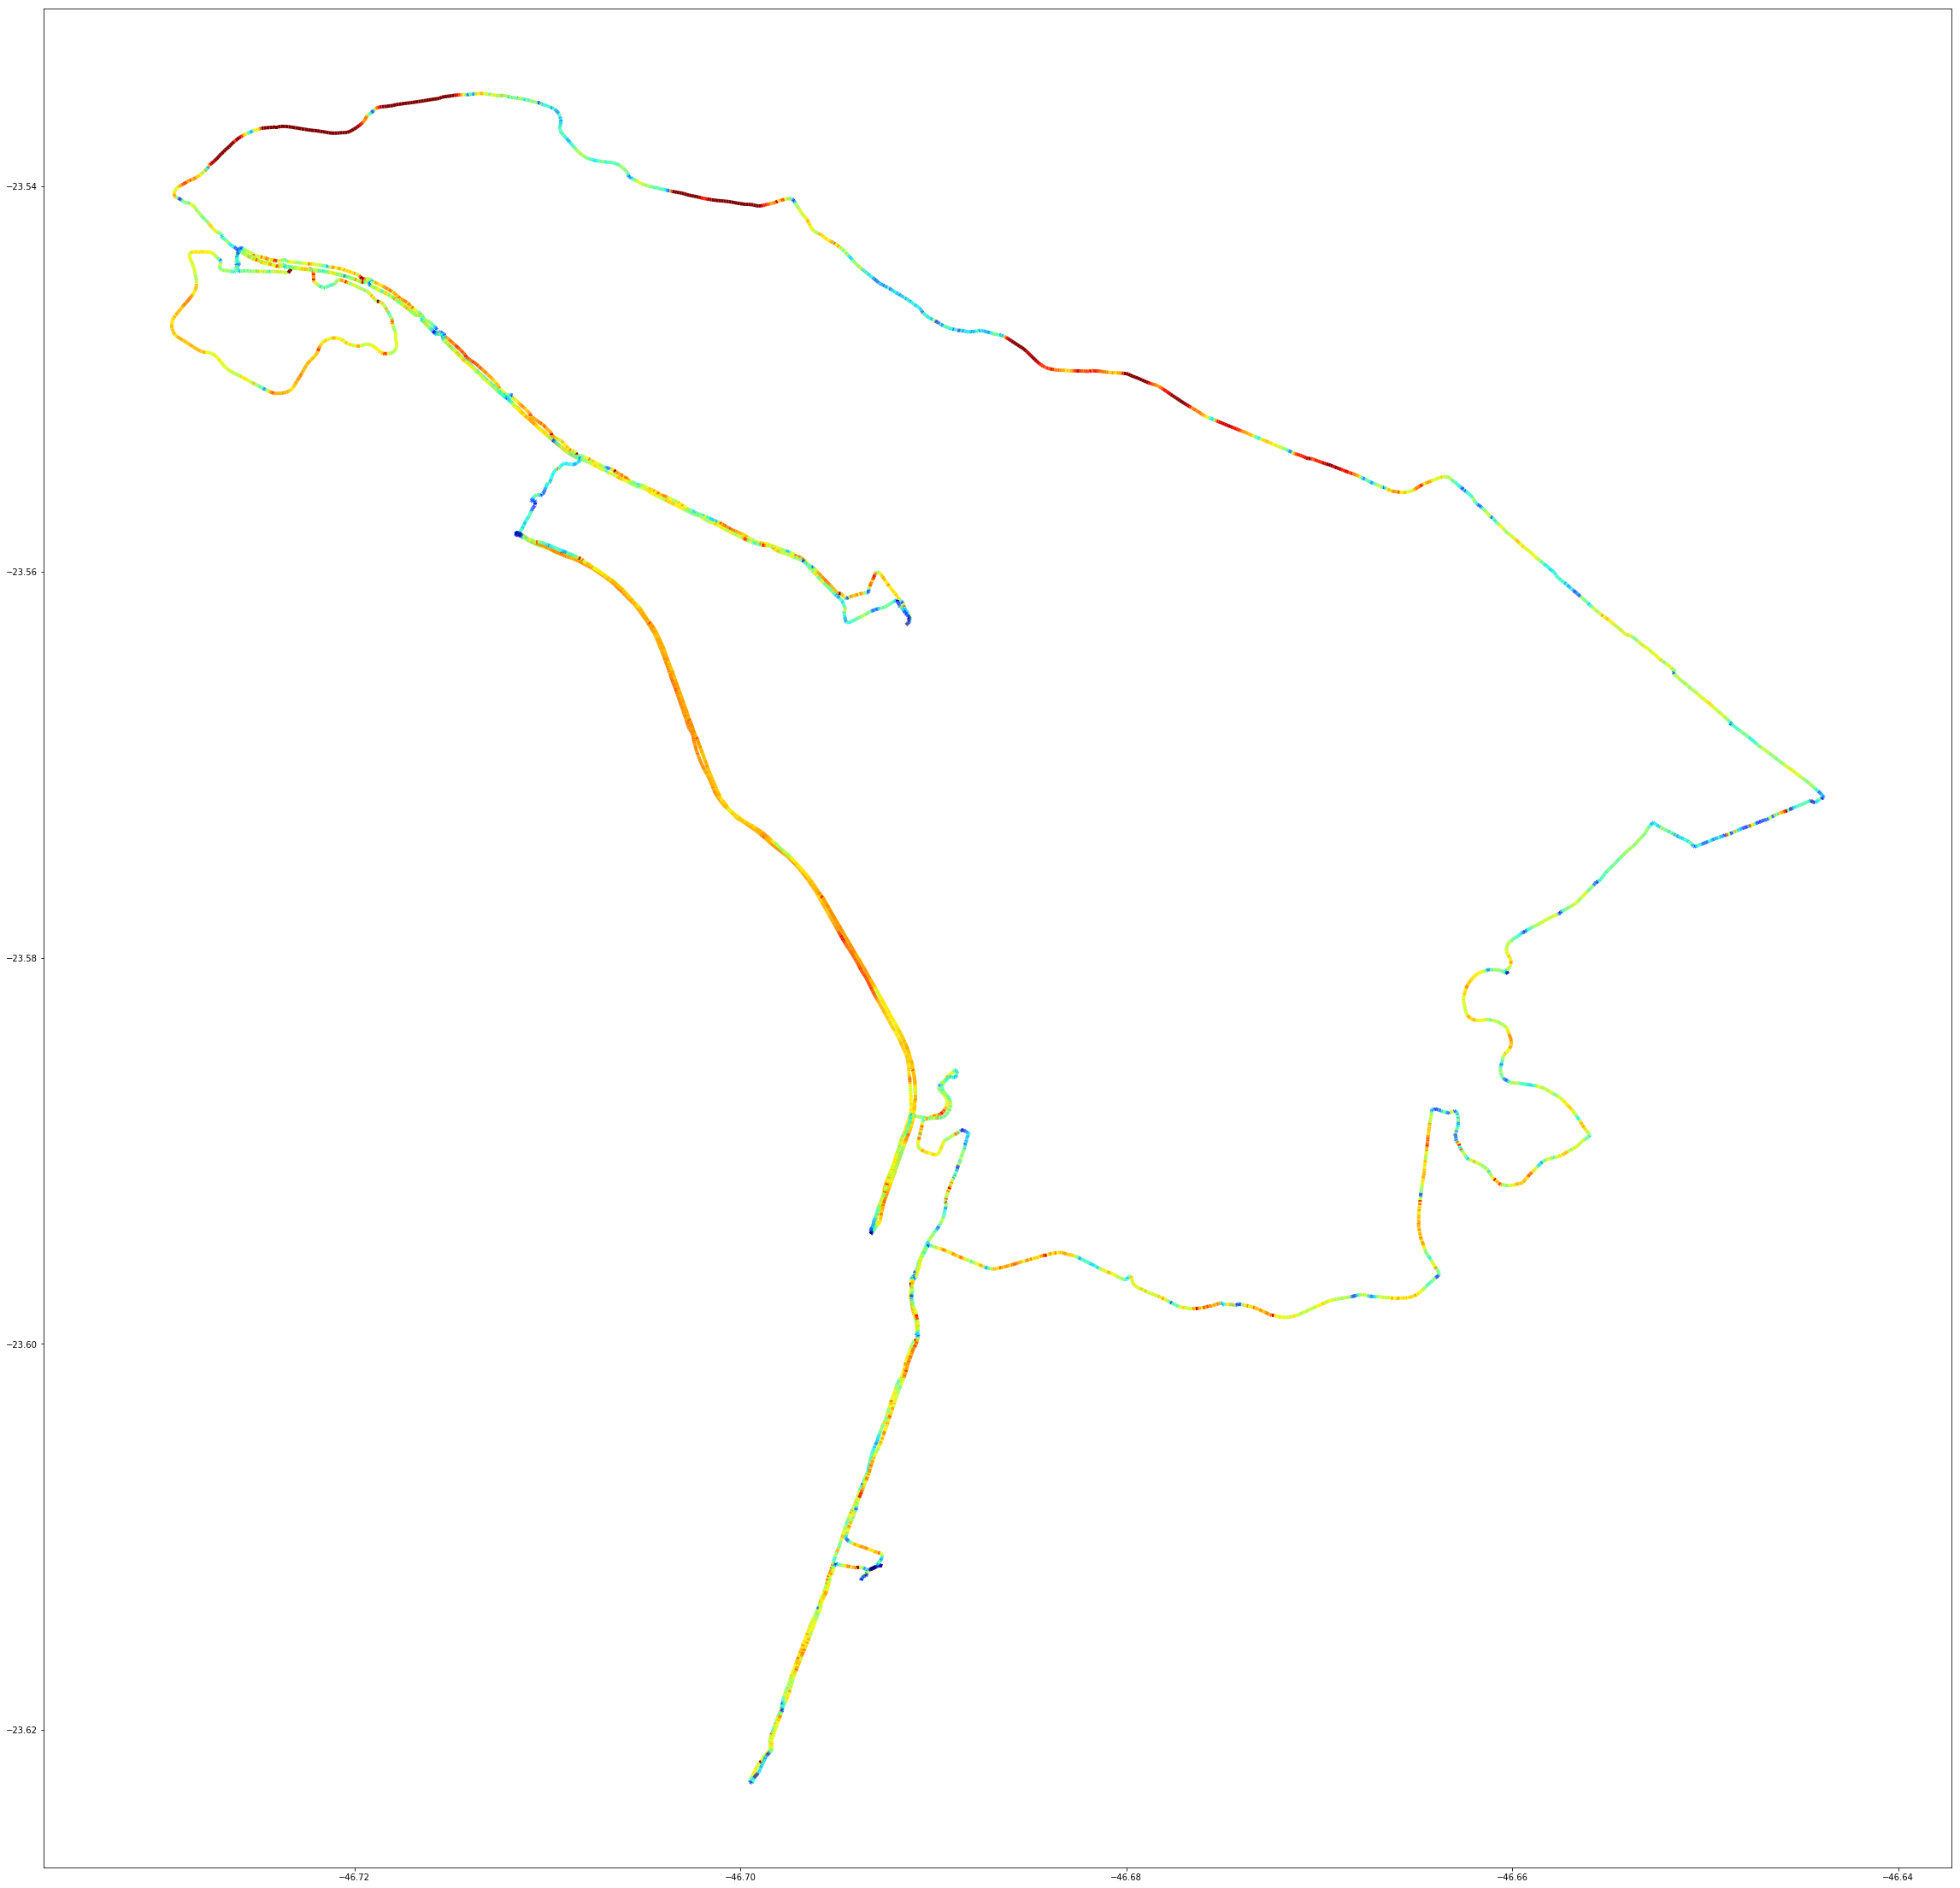

In [233]:
n = 200
c = data.loc[0].loc[ride].head(n)
c = c.append(data.loc[0].loc[0].tail(n))
c = c.append(data.loc[0].loc[1].head(n//2))
c = c.append(data.loc[0].loc[1].tail(n))
c = c.append(data.loc[0].loc[2].head(n))
c = c.append(data.loc[0].loc[2].tail(n))
c = c.append(data.loc[0].loc[4].head(n//2))
c = c.append(data.loc[0].loc[4].tail(n))
norm = colors.Normalize()
cmap = plt.cm.get_cmap('jet')
rgba = cmap(norm(c.dist))

plt.figure(figsize=(20,20))
plt.subplot(221).quiver(c.ilon, c.ilat, c.flon-c.ilon, c.flat-c.ilat, color=rgba, units='xy', angles='xy', scale=1, pivot='tail')
plt.axis('equal')

plt.subplot(222).scatter(c.ilon, c.ilat, color=rgba, s=0.2)
plt.axis('equal')
plt.show()


c = data.loc[0].loc[0]

c['glat'] = np.around(c.ilat, 1)
c['glon'] = np.around(c.ilon, 1)
c['gdir'] = round(c.heading/45)*45

group = c.groupby(['glat', 'glon', 'gdir'], axis=0)
distancemean = pd.DataFrame(group['dist'].mean())
latmean = pd.DataFrame(group['ilat'].mean())
lonmean = pd.DataFrame(group['ilon'].mean())

c = c.merge(latmean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
c = c.merge(lonmean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
c = c.merge(distancemean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
c = c.sort_values(['rider', 'itime'])

xy = np.array((c.ilon, c.ilat)).T #Nx2
xy = xy.reshape(-1, 1, 2)
segments = np.hstack([xy[:-1], xy[1:]])
g, ax = plt.subplots(figsize=(40,40))
collection = LineCollection(segments, cmap='jet', linewidth=4)
collection.set_array(norm(c.dist, 10))
ax.add_collection(collection)
ax.autoscale_view()
ax.axis('equal')
plt.show()

